In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_excel('../data/SPY.xlsx')
df.columns = df.iloc[5].values
df = df.iloc[6:].iloc[::-1].reset_index(drop=True)
df['Log Return'] = df.PX_LAST.apply(lambda x: np.log(x)).diff()
df.head()

,Date,PX_LAST,Change,% Change,PX_OPEN,Change,% Change,PX_HIGH,Change,% Change,PX_LOW,Change,% Change,Log Return
0,1993-01-29 00:00:00,25.2238,NaN,NaN,25.2417,NaN,NaN,25.2417,NaN,NaN,25.1161,NaN,NaN,NaN
1,1993-02-01 00:00:00,25.4032,NaN,NaN,25.2417,NaN,NaN,25.4032,NaN,NaN,25.2417,NaN,NaN,0.007087
2,1993-02-02 00:00:00,25.457,NaN,NaN,25.3852,NaN,NaN,25.4749,NaN,NaN,25.3314,NaN,NaN,0.002116
3,1993-02-03 00:00:00,25.7261,NaN,NaN,25.4929,NaN,NaN,25.744,NaN,NaN,25.4749,NaN,NaN,0.010515
4,1993-02-04 00:00:00,25.8337,NaN,NaN,25.8158,NaN,NaN,25.8876,NaN,NaN,25.762,NaN,NaN,0.004174


In [151]:
def symmetric(y, beta, q):
    VaR = np.zeros_like(y)
    VaR[0] = np.quantile(y[:300], q)
    
    b1, b2, b3 = beta
    for i in range(1, len(y)):
        VaR[i] = b1 + b2 * VaR[i-1] + b3 * abs(y[i-1])
    
    return VaR

def loss(y, VaR, q):
    dev = y - VaR
    return np.sum(np.maximum(q * dev, (q - 1) * dev))

def sigmoid(x, G):
    """
    mimic indicator function I(x<=0)
    """
    return 1 / (1 + np.exp(G*x))

def get_gradient(y, beta, VaR, q, G):
    """
      d(RQ)/dbeta
    = sum[ (q - sigmoid(y - f(beta))) * d(y - f(beta))/dbeta +
           (y - f(beta)) * d(q - sigmoid(y - f(beta)))/dbeta ]
    """
    gradient = np.zeros_like(beta)
    
    dev = y - VaR
    sigmoid_dev = sigmoid(dev, G)
    for t in range(1, len(y)):
        gradient[0] += (
            (q - sigmoid_dev[t]) * (-1) +
            dev[t] * (-1 * (sigmoid_dev[t] * (1 - sigmoid_dev[t]) * G * (- 1)))
        )
        
        gradient[1] += (
            (q - sigmoid_dev[t]) * (- VaR[t-1]) +
            dev[t] * (-1 * (sigmoid_dev[t] * (1 - sigmoid_dev[t]) * G * (- VaR[t-1])))
        )
        
        gradient[2] += (
            (q - sigmoid_dev[t]) * (- abs(y[t-1])) +
            dev[t] * (-1 * (sigmoid_dev[t] * (1 - sigmoid_dev[t]) * G * (- abs(y[t-1]))))
        )
    
    return gradient

def gradient_descent(y, q=0.05, G=50, learning_rate=0.00005, max_iter=1000, tol=1e-10):
    y = np.array(y)
    beta = np.random.uniform(-0.001, 0.001, 3)
    VaR = symmetric(y, beta, q)
    last = loss(y, VaR, q)
    print(f'[0/{max_iter}] Loss: {last:.4f}')
    
    for i in range(max_iter):
        gradient = get_gradient(y, beta, VaR, q, G)
        beta -= learning_rate * gradient
        VaR = symmetric(y, beta, q)
        current = loss(y, VaR, q)
        print(f'[{i+1}/{max_iter}] Loss: {current:.4f} Beta: {beta}')
        
        if last - current < tol:
            print('Early stopped.')
            print(f'Final Loss: {current:.4f} Beta: {beta}')
            return beta + learning_rate * gradient
        
        last = current
    
    print(f'Finished {max_iter} loop')
    print(f'Final Loss: {current:.4f}')
    return beta

def adam(grad_fn, x0, num_iters=1000, alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
    # Initialize variables
    m = np.zeros_like(x0)
    v = np.zeros_like(x0)
    x = x0
    
    # Optimization loop
    for t in range(num_iters):
        # Evaluate gradient and compute moving averages of gradient and squared gradient
        grad = grad_fn(x)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * np.square(grad)
        
        # Compute bias-corrected moving averages
        m_hat = m / (1 - beta1 ** (t + 1))
        v_hat = v / (1 - beta2 ** (t + 1))
        
        # Update parameters
        x -= alpha * m_hat / (np.sqrt(v_hat) + eps)
    
    return x

In [152]:
returns = (df['Log Return'].dropna() - df['Log Return'].dropna().mean()).reset_index(drop=True) * 100

In [153]:
beta = np.array([-0.0360569 ,  0.91599347, -0.14813257]) # [-0.03671756  0.9153824  -0.14871019]

[0/1000] Loss: 2993.1978
[1/1000] Loss: 2283.3361 Beta: [-0.16322233 -0.00030609 -0.12766294]
[2/1000] Loss: 1923.7982 Beta: [-0.2735031   0.03010804 -0.21068521]
[3/1000] Loss: 1678.7330 Beta: [-0.35819757  0.07103051 -0.27306981]


C:\Users\Jasper\AppData\Local\Temp\ipykernel_10988\1190941538.py:19: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(G*x))


[4/1000] Loss: 1503.6079 Beta: [-0.4239261   0.115439   -0.32102548]
[5/1000] Loss: 1370.6562 Beta: [-0.47625     0.15988353 -0.35858405]
[6/1000] Loss: 1269.0972 Beta: [-0.5178943   0.20249007 -0.38847939]
[7/1000] Loss: 1194.7955 Beta: [-0.55057932  0.24134283 -0.41167079]
[8/1000] Loss: 1140.4088 Beta: [-0.57582731  0.27586515 -0.42970213]
[9/1000] Loss: 1101.5499 Beta: [-0.59523511  0.30578375 -0.4435138 ]
[10/1000] Loss: 1073.6105 Beta: [-0.61027813  0.33168048 -0.45406721]
[11/1000] Loss: 1053.3519 Beta: [-0.62207263  0.35399641 -0.46232448]
[12/1000] Loss: 1039.1669 Beta: [-0.63103625  0.37279757 -0.46885007]
[13/1000] Loss: 1029.8220 Beta: [-0.63779852  0.38840068 -0.47369295]
[14/1000] Loss: 1023.5216 Beta: [-0.64270078  0.40108288 -0.47700244]
[15/1000] Loss: 1019.0746 Beta: [-0.64638654  0.41192785 -0.47931492]
[16/1000] Loss: 1016.0648 Beta: [-0.64895243  0.42102448 -0.48080366]
[17/1000] Loss: 1013.9030 Beta: [-0.65068868  0.42882675 -0.48177884]
[18/1000] Loss: 1012.2982 

[123/1000] Loss: 994.1688 Beta: [-0.48092465  0.59130583 -0.37330553]
[124/1000] Loss: 994.0227 Beta: [-0.47922514  0.59245445 -0.3725117 ]
[125/1000] Loss: 993.8759 Beta: [-0.47752601  0.59360357 -0.3717193 ]
[126/1000] Loss: 993.7285 Beta: [-0.4758274   0.59475356 -0.37092847]
[127/1000] Loss: 993.5805 Beta: [-0.47412939  0.59590474 -0.37013935]
[128/1000] Loss: 993.4317 Beta: [-0.47243205  0.59705742 -0.36935206]
[129/1000] Loss: 993.2821 Beta: [-0.47073545  0.59821184 -0.36856673]
[130/1000] Loss: 993.1318 Beta: [-0.46903959  0.59936821 -0.36778346]
[131/1000] Loss: 992.9809 Beta: [-0.46734446  0.60052672 -0.36700239]
[132/1000] Loss: 992.8293 Beta: [-0.46565004  0.60168746 -0.36622363]
[133/1000] Loss: 992.6768 Beta: [-0.46395626  0.60285047 -0.36544729]
[134/1000] Loss: 992.5234 Beta: [-0.462263    0.60401568 -0.36467349]
[135/1000] Loss: 992.3691 Beta: [-0.46057011  0.60518289 -0.36390231]
[136/1000] Loss: 992.2139 Beta: [-0.45887741  0.6063517  -0.36313381]
[137/1000] Loss: 992

[244/1000] Loss: 970.5865 Beta: [-0.2735442   0.72960455 -0.29572546]
[245/1000] Loss: 970.3697 Beta: [-0.27191079  0.73055925 -0.29524243]
[246/1000] Loss: 970.1544 Beta: [-0.27028859  0.7315098  -0.29475992]
[247/1000] Loss: 969.9462 Beta: [-0.2686822   0.73248089 -0.29428477]
[248/1000] Loss: 969.7387 Beta: [-0.26708597  0.73346414 -0.29381404]
[249/1000] Loss: 969.5331 Beta: [-0.26549087  0.73442398 -0.29333715]
[250/1000] Loss: 969.3303 Beta: [-0.26390209  0.73536868 -0.29285666]
[251/1000] Loss: 969.1274 Beta: [-0.26232529  0.73631825 -0.2923784 ]
[252/1000] Loss: 968.9241 Beta: [-0.26076022  0.73727951 -0.29190417]
[253/1000] Loss: 968.7199 Beta: [-0.25920408  0.73825137 -0.29143349]
[254/1000] Loss: 968.5151 Beta: [-0.25765387  0.73922934 -0.29096505]
[255/1000] Loss: 968.3095 Beta: [-0.25610711  0.74020686 -0.29049726]
[256/1000] Loss: 968.1039 Beta: [-0.254562    0.74117411 -0.2900283 ]
[257/1000] Loss: 967.8996 Beta: [-0.25301789  0.74211809 -0.28955639]
[258/1000] Loss: 967

[363/1000] Loss: 952.3938 Beta: [-0.11947974  0.83468752 -0.22825827]
[364/1000] Loss: 952.2631 Beta: [-0.11838032  0.83548439 -0.22771918]
[365/1000] Loss: 952.1323 Beta: [-0.11728548  0.83627753 -0.2271773 ]
[366/1000] Loss: 952.0015 Beta: [-0.11619537  0.83706713 -0.22663172]
[367/1000] Loss: 951.8709 Beta: [-0.11511028  0.83785371 -0.22608171]
[368/1000] Loss: 951.7423 Beta: [-0.11403057  0.83863803 -0.22552675]
[369/1000] Loss: 951.6143 Beta: [-0.11295668  0.83942108 -0.22496656]
[370/1000] Loss: 951.4881 Beta: [-0.11188906  0.84020396 -0.22440115]
[371/1000] Loss: 951.3644 Beta: [-0.11082822  0.84098793 -0.22383093]
[372/1000] Loss: 951.2421 Beta: [-0.10977462  0.84177428 -0.22325673]
[373/1000] Loss: 951.1206 Beta: [-0.10872867  0.84256432 -0.22267987]
[374/1000] Loss: 951.0031 Beta: [-0.1076906   0.84335911 -0.2221021 ]
[375/1000] Loss: 950.8860 Beta: [-0.10666026  0.844159   -0.2215252 ]
[376/1000] Loss: 950.7702 Beta: [-0.10563686  0.84496278 -0.22095028]
[377/1000] Loss: 950

0.04910655195234944

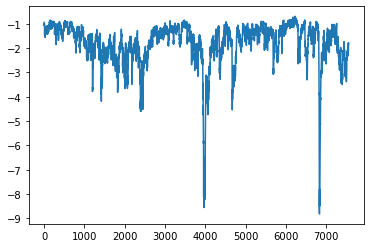

In [154]:
beta = gradient_descent(returns)
VaR = symmetric(returns, beta, q=0.05)
plt.plot(VaR)
np.sum(returns <= VaR) / len(returns)